# Challenge 1 - Getting started <img align="right" src="../Supplementary_data/EY_logo.png" style="margin:0px 50px">

Welcome to the 2021 Better Working World Data Challenge! 

This notebook will show you how to open and explore the data, identify problematic areas of the data, create a basic solution to the problem, and submit your results via the EY Data Science platform.

Prior to running this notebook, make sure you have:
* **Created a profile** on the [EY Data Science Platform](https://datascience.ey.com/)
* **Registered** for "Challenge 1: Fire mapping" on the Platform

We also recommend checking out the resources in the "01_Beginners_guide" folder to learn about jupyter notebooks and the Open Data Cube before coming back here.

### Your task

The training dataset contains 129 linescan images (infra-red images taken from an airplane) of bushfires in Victoria, Australia, during the first three months of 2019. There are also polygons showing where the fire is in each image, which have been hand-drawn by our collaborators at the Country Fire Authority (CFA). These polygons are the ground truth your solution should be able to recreate.

There are an additional 5 linescan images, the test dataset, where the polygons showing the fire boundaries have not been provided. Your task is to train a model or process which can produce a fire boundary for the remaining 5 linescans with no polygon.

All the linescan images (both the traning and test sets) are served via the Open Data Cube python library. The polygons are already available in your environment.

### Import libraries and instantiate a datacube

In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime

from datacube import Datacube
import matplotlib.pyplot as plt

import tqdm
from odc.ui import with_ui_cbk # progress_cbk=with_ui_cbk(),

sys.path.append("../scripts")
from dea_plotting import map_shapefile
from dea_spatialtools import xr_rasterize

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
dc = Datacube(app="Data Preparation")

## Import variables
### Import input variable: aerial linescan images

Firstly, let's query the datacube object to identify what linescans are available. We'll also sort them by ID to ensure they're ordered consistently for this guide.

In [3]:
linescan_datasets = dc.find_datasets(product='linescan')
linescan_datasets = sorted(linescan_datasets, key = lambda ds: (ds.center_time, ds.id))

print(f'\nNumber of linescan datasets: {len(linescan_datasets)}')


Number of linescan datasets: 134


The results stored in `linescan_datasets` are metadata which describe the various linescan files, including the filename (called the 'label'), extent, date and time of acquisition, and an ID number for that dataset.  Not until we load the dataset can we actually read or view the data. The cell below loads a single linescan from the available list.

In [4]:
train = pd.read_csv('resources/challenge1_train.csv', index_col='id')
print(train.head())
print(f'\nNumber of training images: {len(train)}')

                                  label     dateTimeLocal       dateTimeUTC
id                                                                         
0     ROSEDALE_P1_201901041439_MGA94_55   4/01/2019 14:39    4/01/2019 3:39
1   ROSEDALE_1_P1_201901041446_MGA94_55   4/01/2019 14:46    4/01/2019 3:46
2   ROSEDALE_3_P1_201901041501_MGA94_55   4/01/2019 15:01    4/01/2019 4:01
3   POINT_H_62_P1_201901162128_MGA94_55  16/01/2019 21:28  16/01/2019 10:28
4   NUNNETT_73_P1_201901171134_MGA94_55  17/01/2019 11:34   17/01/2019 0:34

Number of training images: 129


In [5]:
train.label.unique()

array(['ROSEDALE_P1_201901041439_MGA94_55',
       'ROSEDALE_1_P1_201901041446_MGA94_55',
       'ROSEDALE_3_P1_201901041501_MGA94_55',
       'POINT_H_62_P1_201901162128_MGA94_55',
       'NUNNETT_73_P1_201901171134_MGA94_55',
       'NUNNETT_88_P1_201901171656_MGA94_55',
       'NUNNETT_96_P1_201901172230_MGA94_55',
       'NUNNETT_107_P1_201901181517_MGA94_55',
       'NUNNETT_121_P1_201901191642_MGA94_55',
       'NUNNETT_128_P1_201901192201_MGA94_55',
       'NUNNETT_173_P1_201901251120_MGA94_55',
       'NUNNETT_174_P1_201901251128_MGA94_55',
       'NUNNETT_175_P1_201901251137_MGA94_55',
       'NUNNETT_176_P1_201901251157_MGA94_55',
       'NUNNETT_177_P1_201901251211_MGA94_55',
       'NUNNETT_179_P1_201901251234_MGA94_55',
       'NUNNETT_180_P1_201901251246_MGA94_55',
       'NUNNETT_181_P1_201901251254_MGA94_55',
       'NUNNETT_182_P1_201901251321_MGA94_55',
       'NUNNETT_183_P1_201901251342_MGA94_55',
       'NUNNETT_184_P1_201901251400_MGA94_55',
       'NUNNETT_185_P1

## Exemple

In [6]:
sample = 132
ds = dc.load(product='linescan', id=linescan_datasets[sample].id, output_crs='epsg:28355', resolution=(-10,10), progress_cbk=with_ui_cbk())
ds

<xarray.Dataset>
Dimensions:      (time: 1, x: 3270, y: 5105)
Coordinates:
  * time         (time) datetime64[ns] 2019-03-16T04:39:00
  * y            (y) float64 5.863e+06 5.863e+06 ... 5.812e+06 5.812e+06
  * x            (x) float64 4.589e+05 4.589e+05 ... 4.916e+05 4.916e+05
    spatial_ref  int32 28355
Data variables:
    linescan     (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:28355
    grid_mapping:  spatial_ref

The 'challenge1_train.csv' file lists the names of all the training linescans that are available.

### Import Target Variable: Fire Map Polygons

Let's load and display the dataset.

In [7]:
vector_file = 'resources/fire_boundaries.shp'
gdf = gpd.read_file(vector_file)
print('Number of objects in geodataframe: ' + str(len(gdf)))

Number of objects in geodataframe: 976


In [8]:
gdf

,Source,SourceName,Type,dtString,Comments,dtUTC,dtLocal,ID,event,geometry
0,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-25 22:55:00,2019-01-26 09:55:00,0,Latrobe86,"POLYGON ((431455.605 5829806.837, 431460.570 5..."
1,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 86 - Jericho - Thomson - Jo...,2019-01-25 22:55:00,2019-01-26 09:55:00,1,Latrobe86,"POLYGON ((433874.449 5827986.798, 433882.377 5..."
2,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 85 - Jericho - Cream Can Hill,2019-01-25 22:55:00,2019-01-26 09:55:00,2,Latrobe86,"POLYGON ((430459.914 5831285.492, 430457.641 5..."
3,Linescan,aberfeldy west 214 p1_201901261750_mga94_55.jpg,Spot,2019/01/26 17:50:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-26 06:50:00,2019-01-26 17:50:00,3,Latrobe86,"POLYGON ((431937.376 5829943.371, 431941.068 5..."
4,Linescan,aberfeldy west 214 p1_201901261750_mga94_55.jpg,Main run,2019/01/26 17:50:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-26 06:50:00,2019-01-26 17:50:00,4,Latrobe86,"POLYGON ((431541.651 5829804.025, 431547.139 5..."
...,...,...,...,...,...,...,...,...,...,...
971,Linescan,yarra51 809 p1_201903161558_mga94_55.jpg,Backburn,2019/03/16 15:58:00.000,None,2019-03-16 04:58:00,2019-03-16 15:58:00,2254,Yarra51,"POLYGON ((400246.624 5838321.274, 400254.524 5..."
972,Linescan,yarra51 809 p1_201903161558_mga94_55.jpg,Spot,2019/03/16 15:58:00.000,None,2019-03-16 04:58:00,2019-03-16 15:58:00,2255,Yarra51,"POLYGON ((400442.749 5839677.640, 400409.760 5..."
973,Linescan,yarra51 809 p1_201903161558_mga94_55.jpg,Backburn,2019/03/16 15:58:00.000,None,2019-03-16 04:58:00,2019-03-16 15:58:00,2256,Yarra51,"POLYGON ((400104.351 5838696.227, 400104.396 5..."
974,Linescan,yarra51 809 p1_201903161558_mga94_55.jpg,Main run,2019/03/16 15:58:00.000,Final scan withfire activity,2019-03-16 04:58:00,2019-03-16 15:58:00,2257,Yarra51,"POLYGON ((404476.742 5834053.367, 404473.745 5..."


## Exploring the Polygon Dataset
While the polygons provided were created from the linescan images, it is not always easy to see exactly which linescan was the source for a given polygon.

### Direct matches
Looking at the linescan dataset metadata, in many cases the linescan label field can be used to match the linescan to a set of polygons using the SourceName field, with some slight changes.

In [9]:
print(linescan_datasets[sample].metadata_doc['label'])

MACALISTER91_808_P1_201903161539_MGA94_55


### Composite Polygons

Another subset of the polygon dataset that will require more careful consideration are polygons derived from multiple linescans. These polygons usually represent larger fires that stretch over many linescan images and are referred to as "composite polygons".

Identifying these polygons is a little trickier and involves searching the SourceName attribute for the word "composite". Some composites might not meet this condition, but will have a list of numbers representing the linescans it was derived from, so in addition to "composite", we will also search for commas and the ampersand symbol '&'. 

The query is as follows:


In [10]:
composites = gdf[gdf.SourceName.str.upper().str.contains(",|&|(COMPOSITE)", na=False)]

print(f"Total composite polygons: {len(composites)}")
composites.SourceName.head()

Total composite polygons: 285


/env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


240    Composite wallhalla 397,398 & 401 20190225 (13...
241    Composite wallhalla 397,398 & 401 20190225 (13...
242    Composite wallhalla 397,398 & 401 20190225 (13...
315    macalister 681 & 682, (684 & 685 minor) compos...
316    macalister 681 & 682, (684 & 685 minor) compos...
Name: SourceName, dtype: object

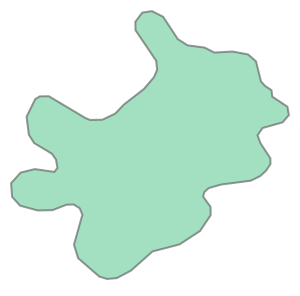

In [11]:
composites.iloc[0].geometry


In [12]:
dict_keys = composites.SourceName.unique()
dict_keys

array(['Composite wallhalla 397,398 & 401 20190225 (1311 to 1342hrs)',
       'macalister 681 & 682, (684 & 685 minor) composite 0517-0539hrs',
       'composite macalister97 803, 806 &  807 1455-1532hrs',
       'macalister91 751, 752, 755, 760, 761 & 762 composite 1549-1730hrs',
       'macalister91 766,767 & 770 composite 1239-1314hrs',
       'macalister91 775, 776, 779 & 783 composite 1345-1643hrs',
       'macalister91 789, 790 & 793 composite 1330-1358hrs',
       'macalister91 804, 805 & 808 composite 1503-1539hrs',
       'macalister91 646,648 & 649 composite - 0440hrs to 0453hrs',
       'macalister 695,698 & 699 composite 1542 - 1610hrs',
       'macalister 696,697,700 - 1545-1613hrs',
       'Composite wallhalla 380 & 381 20190206 (1347 & 1356hrs)'],
      dtype=object)

In [13]:
fires = ['wallhalla','macalister91','macalister97','macalister']
dictt = {}
for k in dict_keys:
    dictt[k] = []
    splitt = k.replace(',',' ').replace('(',' ').split(' ')
    for f in fires:
        try:
            ff = splitt[splitt.index(f)]
            break
        except: pass
    for w in splitt:
        if len(w)==3:
            try:
                int(w)
                dictt[k].append(ff+'_' + w)               
            except: pass

In [14]:
print(composites.SourceName.iloc[0])
composites.iloc[0]

Composite wallhalla 397,398 & 401 20190225 (1311 to 1342hrs)


Source                                                 Linescan
SourceName    Composite wallhalla 397,398 & 401 20190225 (13...
Type                                                       Spot
dtString                                2019/02/25 13:40:00.000
Comments                                                   None
dtUTC                                       2019-02-25 02:40:00
dtLocal                                     2019-02-25 13:40:00
ID                                                         2051
event                                                  Walhalla
geometry      POLYGON ((453658.6667487729 5803930.428893661,...
Name: 240, dtype: object

In [15]:
compo_cleaned = pd.DataFrame(columns = composites.columns)

for l in range(len(composites)):
    for cell in dictt[composites.iloc[l].SourceName]:
        compo_cleaned = compo_cleaned.append(composites.iloc[l])
        compo_cleaned.SourceName.iloc[-1] = cell

In [16]:
# clean the name

compo_cleaned.SourceName = compo_cleaned.apply(lambda row: row.SourceName +'_P1_' + row.dtString.replace(' ','').replace(':','').replace('/','')[:12] + '_mga94_55', axis =1)

In [17]:
mask= pd.Series(gdf.SourceName.str.upper().str.contains(",|&|(COMPOSITE)", na=False), index = gdf.index)


In [18]:
gdf[mask].shape, gdf.shape, gdf[pd.Series(1 - mask, dtype= bool)].shape

((285, 10), (976, 10), (691, 10))

In [19]:
new_gdf = pd.concat([gdf[pd.Series(1 - mask, dtype= bool)],compo_cleaned ])
new_gdf

,Source,SourceName,Type,dtString,Comments,dtUTC,dtLocal,ID,event,geometry
0,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-25 22:55:00,2019-01-26 09:55:00,0,Latrobe86,"POLYGON ((431455.605 5829806.837, 431460.570 5..."
1,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 86 - Jericho - Thomson - Jo...,2019-01-25 22:55:00,2019-01-26 09:55:00,1,Latrobe86,"POLYGON ((433874.449 5827986.798, 433882.377 5..."
2,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 85 - Jericho - Cream Can Hill,2019-01-25 22:55:00,2019-01-26 09:55:00,2,Latrobe86,"POLYGON ((430459.914 5831285.492, 430457.641 5..."
3,Linescan,aberfeldy west 214 p1_201901261750_mga94_55.jpg,Spot,2019/01/26 17:50:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-26 06:50:00,2019-01-26 17:50:00,3,Latrobe86,"POLYGON ((431937.376 5829943.371, 431941.068 5..."
4,Linescan,aberfeldy west 214 p1_201901261750_mga94_55.jpg,Main run,2019/01/26 17:50:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-26 06:50:00,2019-01-26 17:50:00,4,Latrobe86,"POLYGON ((431541.651 5829804.025, 431547.139 5..."
...,...,...,...,...,...,...,...,...,...,...
829,Linescan,wallhalla_398_P1_201902251340_mga94_55,Spot,2019/02/25 13:40:00.000,None,2019-02-25 02:40:00,2019-02-25 13:40:00,2082,Walhalla,"POLYGON ((449872.713 5798234.831, 449882.400 5..."
829,Linescan,wallhalla_401_P1_201902251340_mga94_55,Spot,2019/02/25 13:40:00.000,None,2019-02-25 02:40:00,2019-02-25 13:40:00,2082,Walhalla,"POLYGON ((449872.713 5798234.831, 449882.400 5..."
830,Linescan,wallhalla_397_P1_201902251340_mga94_55,Spot,2019/02/25 13:40:00.000,None,2019-02-25 02:40:00,2019-02-25 13:40:00,2083,Walhalla,"POLYGON ((449963.353 5796499.473, 449990.358 5..."
830,Linescan,wallhalla_398_P1_201902251340_mga94_55,Spot,2019/02/25 13:40:00.000,None,2019-02-25 02:40:00,2019-02-25 13:40:00,2083,Walhalla,"POLYGON ((449963.353 5796499.473, 449990.358 5..."


### Cleaning Up Polygon Dataset

Let's work on the string formatting first. The format is slightly different between the linescan label field and the polygon SourceName field. The white spaces have been replaced with underscores and the '.jpg' at the end of the filename has been removed, and its in upper case. To clean up the SourceName field in the polygon dataset, first we create a function and test it, and then apply it across the dataset. We also need to make sure we keep in mind that composite SourceNames don't have a '.jpg' at the end, and so should be treated slightly differently.

In the same step, we'll also format the datetime fields in the same step as they're currently formatted as strings. 


In [20]:
def clean_name(name):
    if name is None:
        return ''
    if name.upper()[-4::] == ".JPG":
        return name.upper()[:-4].replace(' ','_')
    return  name.upper().replace(' ','_')

test_string = 'aberfeldy west 200 p1_201901260955_mga94_55.jpg'
test_string_composite = 'Composite wallhalla 397,398 & 401 20190225 (1311 to 1342hrs)'
print(clean_name(test_string))
print(clean_name(test_string_composite))

ABERFELDY_WEST_200_P1_201901260955_MGA94_55
COMPOSITE_WALLHALLA_397,398_&_401_20190225_(1311_TO_1342HRS)


In [21]:
gdf['SourceNameClean'] = gdf.apply(lambda row: clean_name(row.SourceName), axis=1)
gdf.dtUTC = gdf.apply(lambda row: datetime.strptime(row.dtUTC, '%Y-%m-%d %H:%M:%S'), axis=1)
gdf.dtLocal = gdf.apply(lambda row: datetime.strptime(row.dtLocal, '%Y-%m-%d %H:%M:%S'), axis=1)
gdf.head().T

,0,1,2,3,4
Source,Linescan,Linescan,Linescan,Linescan,Linescan
SourceName,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 214 p1_201901261750_mga94_55.jpg,aberfeldy west 214 p1_201901261750_mga94_55.jpg
Type,Initial ignition,Initial ignition,Initial ignition,Spot,Main run
dtString,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000,2019/01/26 17:50:00.000,2019/01/26 17:50:00.000
Comments,originally Latrobe 87 - Jericho - Jim Track,originally Latrobe 86 - Jericho - Thomson - Jo...,originally Latrobe 85 - Jericho - Cream Can Hill,originally Latrobe 87 - Jericho - Jim Track,originally Latrobe 87 - Jericho - Jim Track
dtUTC,2019-01-25 22:55:00,2019-01-25 22:55:00,2019-01-25 22:55:00,2019-01-26 06:50:00,2019-01-26 06:50:00
dtLocal,2019-01-26 09:55:00,2019-01-26 09:55:00,2019-01-26 09:55:00,2019-01-26 17:50:00,2019-01-26 17:50:00
ID,0,1,2,3,4
event,Latrobe86,Latrobe86,Latrobe86,Latrobe86,Latrobe86
geometry,"POLYGON ((431455.6047864075 5829806.836519156,...","POLYGON ((433874.4491466696 5827986.798174933,...","POLYGON ((430459.9135101112 5831285.491971598,...","POLYGON ((431937.3755649604 5829943.370969374,...","POLYGON ((431541.6507835893 5829804.025387563,..."


In [22]:
new_gdf['SourceNameClean'] = new_gdf.apply(lambda row: clean_name(row.SourceName), axis=1)
new_gdf.dtUTC = new_gdf.apply(lambda row: datetime.strptime(row.dtUTC, '%Y-%m-%d %H:%M:%S'), axis=1)
new_gdf.dtLocal = new_gdf.apply(lambda row: datetime.strptime(row.dtLocal, '%Y-%m-%d %H:%M:%S'), axis=1)
new_gdf.head()

,Source,SourceName,Type,dtString,Comments,dtUTC,dtLocal,ID,event,geometry,SourceNameClean
0,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-25 22:55:00,2019-01-26 09:55:00,0,Latrobe86,"POLYGON ((431455.605 5829806.837, 431460.570 5...",ABERFELDY_WEST_200_P1_201901260955_MGA94_55
1,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 86 - Jericho - Thomson - Jo...,2019-01-25 22:55:00,2019-01-26 09:55:00,1,Latrobe86,"POLYGON ((433874.449 5827986.798, 433882.377 5...",ABERFELDY_WEST_200_P1_201901260955_MGA94_55
2,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 85 - Jericho - Cream Can Hill,2019-01-25 22:55:00,2019-01-26 09:55:00,2,Latrobe86,"POLYGON ((430459.914 5831285.492, 430457.641 5...",ABERFELDY_WEST_200_P1_201901260955_MGA94_55
3,Linescan,aberfeldy west 214 p1_201901261750_mga94_55.jpg,Spot,2019/01/26 17:50:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-26 06:50:00,2019-01-26 17:50:00,3,Latrobe86,"POLYGON ((431937.376 5829943.371, 431941.068 5...",ABERFELDY_WEST_214_P1_201901261750_MGA94_55
4,Linescan,aberfeldy west 214 p1_201901261750_mga94_55.jpg,Main run,2019/01/26 17:50:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-26 06:50:00,2019-01-26 17:50:00,4,Latrobe86,"POLYGON ((431541.651 5829804.025, 431547.139 5...",ABERFELDY_WEST_214_P1_201901261750_MGA94_55


### une rapide analyse montre que plein de polygone ne sont pas dans les donnees train

In [23]:
xlabels = [k[:-25] for k in train.label.unique()]
ylabels = [k[:-25] for k in new_gdf.SourceNameClean.unique()]
aga = pd.DataFrame([(y,y in xlabels) for y in ylabels], columns = ['value','in_label_file'])
aga.in_label_file.mean()

0.6630434782608695

In [24]:
agaga = pd.DataFrame([(k, k in train.label.unique()) for k in new_gdf.SourceNameClean.unique()],
                     columns = ['value','in_label_file'])
agaga.in_label_file.mean()

0.40217391304347827

## create files

In [89]:
new_gdf.crs = 'epsg:28355'

In [102]:
the_big_list = []
for sample in tqdm.tqdm(range(len(train))):
    fname = linescan_datasets[sample].metadata_doc['label']
    ob = new_gdf.loc[new_gdf.SourceNameClean == fname]
    
    # print(f"There are {len(ob)} polygons for linescan {fname}")
    src = dc.load(product='linescan', id=linescan_datasets[sample].id, output_crs='epsg:28355', resolution=(-10,10))
    if len(ob)>0:
        tgt = xr_rasterize(gdf=ob, da=src)
    else:
        tgt = src.linescan[0]*0
    the_big_list.append({'input': src.linescan,  'target': tgt})

 19%|█▊        | 24/129 [00:20<01:50,  1.05s/it]

Rasterizing to match xarray.DataArray dimensions (777, 1171)


 21%|██        | 27/129 [00:21<01:09,  1.46it/s]

Rasterizing to match xarray.DataArray dimensions (1297, 3333)


 22%|██▏       | 28/129 [00:22<01:18,  1.29it/s]

Rasterizing to match xarray.DataArray dimensions (1873, 2125)


 23%|██▎       | 30/129 [00:23<01:05,  1.52it/s]

Rasterizing to match xarray.DataArray dimensions (2052, 2196)


 25%|██▍       | 32/129 [00:25<01:13,  1.33it/s]

Rasterizing to match xarray.DataArray dimensions (2022, 2435)


 26%|██▋       | 34/129 [00:27<01:26,  1.09it/s]

Rasterizing to match xarray.DataArray dimensions (2295, 1799)


 27%|██▋       | 35/129 [00:28<01:34,  1.01s/it]

Rasterizing to match xarray.DataArray dimensions (1908, 2142)


 28%|██▊       | 36/129 [00:29<01:22,  1.12it/s]

Rasterizing to match xarray.DataArray dimensions (1963, 2224)


 30%|███       | 39/129 [00:32<01:18,  1.15it/s]

Rasterizing to match xarray.DataArray dimensions (1753, 1934)


 31%|███       | 40/129 [00:33<01:15,  1.17it/s]

Rasterizing to match xarray.DataArray dimensions (3314, 1683)


 33%|███▎      | 42/129 [00:34<01:00,  1.44it/s]

Rasterizing to match xarray.DataArray dimensions (2440, 2132)


 40%|███▉      | 51/129 [00:39<00:52,  1.48it/s]

Rasterizing to match xarray.DataArray dimensions (2847, 2720)


 51%|█████     | 66/129 [00:57<01:17,  1.22s/it]

Rasterizing to match xarray.DataArray dimensions (3509, 3770)


 54%|█████▍    | 70/129 [01:00<00:44,  1.31it/s]

Rasterizing to match xarray.DataArray dimensions (3981, 2973)


 57%|█████▋    | 73/129 [01:02<00:40,  1.37it/s]

Rasterizing to match xarray.DataArray dimensions (3736, 3548)


 57%|█████▋    | 74/129 [01:03<00:38,  1.41it/s]

Rasterizing to match xarray.DataArray dimensions (4124, 3915)


 58%|█████▊    | 75/129 [01:03<00:35,  1.53it/s]

Rasterizing to match xarray.DataArray dimensions (3531, 2005)


 60%|█████▉    | 77/129 [01:05<00:34,  1.49it/s]

Rasterizing to match xarray.DataArray dimensions (3584, 2623)


 62%|██████▏   | 80/129 [01:06<00:30,  1.58it/s]

Rasterizing to match xarray.DataArray dimensions (2855, 2389)


 64%|██████▍   | 83/129 [01:09<00:32,  1.43it/s]

Rasterizing to match xarray.DataArray dimensions (3075, 2637)


 68%|██████▊   | 88/129 [01:12<00:25,  1.61it/s]

Rasterizing to match xarray.DataArray dimensions (3313, 2770)


 69%|██████▉   | 89/129 [01:13<00:28,  1.40it/s]

Rasterizing to match xarray.DataArray dimensions (3924, 2792)


 71%|███████▏  | 92/129 [01:16<00:34,  1.07it/s]

Rasterizing to match xarray.DataArray dimensions (2864, 2625)


 72%|███████▏  | 93/129 [01:17<00:30,  1.18it/s]

Rasterizing to match xarray.DataArray dimensions (3164, 2068)


 74%|███████▎  | 95/129 [01:18<00:26,  1.28it/s]

Rasterizing to match xarray.DataArray dimensions (4447, 3094)


 74%|███████▍  | 96/129 [01:19<00:23,  1.38it/s]

Rasterizing to match xarray.DataArray dimensions (2844, 2291)


 75%|███████▌  | 97/129 [01:19<00:24,  1.31it/s]

Rasterizing to match xarray.DataArray dimensions (3512, 2711)


 76%|███████▌  | 98/129 [01:20<00:25,  1.20it/s]

Rasterizing to match xarray.DataArray dimensions (3416, 1878)


 82%|████████▏ | 106/129 [01:26<00:18,  1.23it/s]

Rasterizing to match xarray.DataArray dimensions (3210, 2264)


 84%|████████▍ | 109/129 [01:31<00:26,  1.31s/it]

Rasterizing to match xarray.DataArray dimensions (3049, 2434)


 85%|████████▌ | 110/129 [01:32<00:21,  1.12s/it]

Rasterizing to match xarray.DataArray dimensions (3052, 2171)


 88%|████████▊ | 113/129 [01:35<00:14,  1.09it/s]

Rasterizing to match xarray.DataArray dimensions (3127, 2378)


 88%|████████▊ | 114/129 [01:35<00:12,  1.19it/s]

Rasterizing to match xarray.DataArray dimensions (3266, 2371)


 89%|████████▉ | 115/129 [01:36<00:11,  1.27it/s]

Rasterizing to match xarray.DataArray dimensions (3132, 2352)


 92%|█████████▏| 119/129 [01:39<00:07,  1.29it/s]

Rasterizing to match xarray.DataArray dimensions (3002, 2469)


 95%|█████████▍| 122/129 [01:43<00:06,  1.03it/s]

Rasterizing to match xarray.DataArray dimensions (3483, 2252)


 97%|█████████▋| 125/129 [01:45<00:03,  1.08it/s]

Rasterizing to match xarray.DataArray dimensions (3381, 1795)


100%|██████████| 129/129 [01:51<00:00,  1.16it/s]


In [105]:
dimensions = np.zeros((len(train),2),dtype=int)
for (d,dico) in enumerate(the_big_list):
    dimensions[d] = dico['target'].shape

In [106]:
dimensions

array([[1409, 1994],
       [1453, 1990],
       [1382, 1687],
       [1216, 1173],
       [1003, 1049],
       [1201, 1045],
       [2036, 1638],
       [ 511, 1430],
       [1478, 1354],
       [1124,  783],
       [1230, 1842],
       [1531, 1985],
       [1474, 1838],
       [2172, 2444],
       [1852, 2605],
       [2833, 4446],
       [2907, 5188],
       [4059, 4101],
       [4752, 4976],
       [4425, 4810],
       [4189, 4266],
       [4308, 4699],
       [3116, 5141],
       [ 777, 1171],
       [ 705, 1217],
       [1599, 1617],
       [1297, 3333],
       [1873, 2125],
       [ 825, 2336],
       [2052, 2196],
       [1280, 2513],
       [2022, 2435],
       [2507, 2870],
       [2295, 1799],
       [1908, 2142],
       [1963, 2224],
       [1905, 2029],
       [2835, 3242],
       [1753, 1934],
       [3314, 1683],
       [1898, 2181],
       [2440, 2132],
       [2315, 2095],
       [2283, 2013],
       [2116, 2099],
       [1959, 2135],
       [2129, 2298],
       [2477,